# Generating names with recurrent neural networks


In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
import keras_utils
import tqdm_utils

1.14.0


Using TensorFlow backend.


# Load data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.



In [2]:
start_token ='_' 
pad_token = "#"

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [3]:
print('number of samples:', len(names))
for x in names[::1000]:
    print(x)

number of samples: 7944
_Abagael
_Claresta
_Glory
_Liliane
_Prissie
_Geeta
_Giovanne
_Piggy


max length: 16


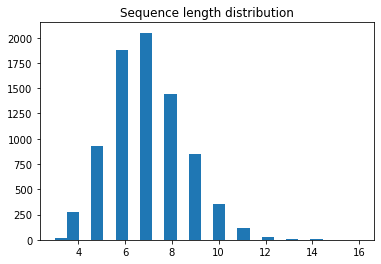

In [4]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

# Text processing



In [5]:
tokens = sorted(set([char for name in names for char in name]))
 ### YOUR CODE HERE: all unique characters go here, padding included!

tokens = list(tokens)
tokens.append('#')
tokens= sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

assert 50 < n_tokens < 60

n_tokens: 57


### Cast everything from symbols into identifiers

Tensorflow string manipulation is a bit tricky, so we'll work around it. 
We'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign `token_to_id`

In [6]:
tok=[]
index=0
for i in tokens:
    tok.append((i,index))
    index+=1
token_to_id = dict(tok)###: create a dictionary of {symbol -> its  index in tokens}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

In [7]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [8]:
# Example: cast 4 random names to padded matrices (so that we can easily batch them)
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

_Abagael
_Glory
_Prissie
_Giovanne
[[30  4 32 31 37 31 35 42  1]
 [30 10 42 45 48 55  1  1  1]
 [30 19 48 39 49 49 39 35  1]
 [30 10 39 45 52 31 44 44 35]]


# Defining a recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="./rnn.png" width=600>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme based on h_t+1

In [127]:
# remember to reset your session if you change your graph!
s = keras_utils.reset_tf_session()

In [109]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization

In [128]:
import keras
from keras.layers import concatenate, Dense, Embedding
from keras.layers.merge import concatenate

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# Let's create layers for our recurrent network
# Note: we create layers but we don't "apply" them yet (this is a "functional API" of Keras)
# Note: set the correct activation (from keras.activations) to Dense layers!

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(64)
get_h_next2=LeakyReLU(0.2)
# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas =Dense(57, activation='softmax')

In [1]:
def rnn_one_step(x_t, h_t):

    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]

    # concatenate x_t embedding and previous h_t state
    x_and_h = concatenate([x_t_emb, h_t])

    # compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    h_next = get_h_next2(h_next)
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)

    return output_probas, h_next

# RNN: loop

Once `rnn_one_step` is ready, let's apply it in a loop over name characters to get predictions.

Let's assume that all names are at most length-16 for now, so we can simply iterate over them in a for loop.


In [133]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

# RNN: loss and gradients

Let's gather a matrix of predictions for $P(x_{next}|h)$ and the corresponding correct answers.


In [134]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

In [123]:
predictions_matrix

<tf.Tensor 'Reshape_19:0' shape=(?, 57) dtype=float32>

In [135]:

loss = keras.losses.categorical_crossentropy(predictions_matrix, answers_matrix)

optimize = tf.train.AdamOptimizer().minimize(loss)

# RNN: training

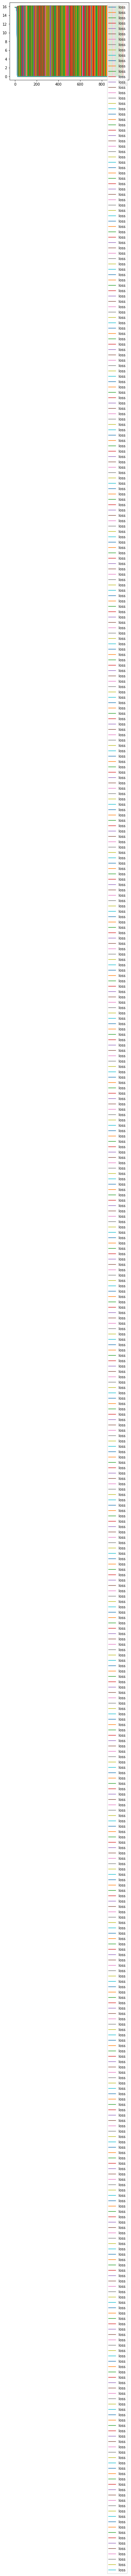

In [136]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"

# RNN: sampling


In [137]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  
next_probs, next_h = rnn_one_step(x_t, h_t)

In [138]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):

    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [143]:
_

9

In [119]:
# without prefix
for _ in range(10):
    print(generate_sample())

_Carr
_Marr
_Marr
_Marr
_Marr
_Marr
_Marr
_Marr
_Marr
_Marr


In [139]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample('_Trump'))

_Trump
_Trump
_Trump
_Trump
_Trump
_Trump
_Trump
_Trump
_Trump
_Trump
